In [1]:
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.io import wavfile
import numpy as np
import pydub
import os
import pickle

# 0. Important Values

In [2]:
# Important frequencies and the colors they correspond to (including higher octaves)
DARKVIOLET = [963, 481.5, 240.75, 120.375]
BLUE = [852, 426, 213, 106.5]
CYAN = [741, 370.5, 185.25, 92.625]
TEAL = [969, 348, 174, 87]
#OLIVEDRAB = [640, 320, 160]
LIME = [639, 319.5, 159.75, 79.875]
MINTCREAM = [570, 285, 142.5, 71.25]
YELLOW = [528, 264, 132, 66]
GOLDENROD = [501.12, 250.56, 125.28]
ORANGE = [417, 208.5, 104.25]
RED = [396, 198, 99]

#lists_of_freqs = [DARKVIOLET, BLUE, CYAN, TEAL, OLIVEDRAB, LIME, MINTCREAM, YELLOW, GOLDENROD, ORANGE, RED]
lists_of_freqs = [DARKVIOLET, BLUE, CYAN, TEAL, LIME, MINTCREAM, YELLOW, GOLDENROD, ORANGE, RED]
for l in lists_of_freqs:
    f = l[0]
    while f <= 11000:
        f *= 2
        l.append(f)

#colors = ['darkviolet', 'blue', 'cyan', 'teal', 'olivedrab', 'lime', 'mintcream', 'yellow', 'goldenrod', 'orange', 'red']
colors = ['darkviolet', 'blue', 'cyan', 'teal', 'lime', 'mintcream', 'yellow', 'goldenrod', 'orange', 'red']

freqs_to_colors = {}
for i in range(len(lists_of_freqs)):
    l = lists_of_freqs[i]
    for f in l:
        freqs_to_colors[f] = colors[i]
important_freqs = sorted(list(freqs_to_colors.keys()))

In [3]:
# Split up frequency spectrum into colored regions
smallest_diff = min([important_freqs[i + 1] - important_freqs[i] for i in range(len(important_freqs) - 1)]) / 2

# 1. Individual Song Analysis

In [4]:
def read_mp3(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
        y = np.mean(y, axis=1)
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

In [6]:
def get_freq_data(f):
    """
    If f has not been analyzed before, this will save the spectrogram results to a .data
    file with the corresponding filename.

    If f has been analyzed before, this will load the results from the .data file with
    the corresponding filename.
    
    Args:
        f (string) = filename of .mp3 file to get spectrogram data for
    Returns:
        freq (list) = frequencies analyzed
        t (list) = segment times
        Sxx (2d list) = spectrogram, where Sxx[i][j] gives the magnitude for frequency i at time j
    """
    
    assert f.endswith('.mp3')
    filepath = '{}.data'.format(f[:-4])
    
    def save_freq_data():
        fs, song = read_mp3(f)
        freq, t, Sxx = signal.spectrogram(song, fs, nfft=44100)
        with open(filepath, 'wb') as filehandle:
            pickle.dump((freq, t, Sxx))
        return freq, t, Sxx
    
    if os.path.exists(filepath):
        with open(filepath, 'rb') as filehandle:
            (freq, t, Sxx) = pickle.load(filepath)
        return freq, t, Sxx
    return save_freq_data()

In [7]:
def analyze(f, t, Sxx):
    """
    Performs analysis on a single song.
    
    Args:
        f (list), t (list), Sxx (2d list) = results from signal.spectrogram of desired song
    Returns:
        median (float) = median of Sxx
        std (float) = standard deviation of Sxx
        count_freq_occurences (list) = number of occurences when a frequency has
            magnitude larger than median + std in Sxx
        largest_nonzero_index (int) = largest index of f that has a nonzero number of
            occurences greater than median + std in Sxx
        peak_freqs (list) = frequencies where there is a peak in the number of
            occurencies greater than median + std in Sxx
    """
    
    # Count the number of occurences when a frequency has a contribution greater than median + std
    median = np.median(Sxx)
    std = np.std(Sxx)
    count_freq_occurences = np.count_nonzero(Sxx > (median + std), axis=1)
    
    # Largest index of f that has a nonzero number of contributions greater than median + std
    largest_nonzero_index = np.max(np.nonzero(count_freq_occurences))
    freqs = f[:largest_nonzero_index]
    counts = count_freq_occurences[:largest_nonzero_index]
    
    # Freqs where there is a peak in number of contributions greater than median + std
    peak_indices = np.nonzero(np.diff((np.diff(counts) > 0).astype(int)) < 0)
    peak_indices = np.array(peak_indices) + 1
    peak_freqs = [freqs[i] for i in peak_indices]
    
    return median, std, count_freq_occurences, largest_nonzero_index, peak_freqs

## 1a. Color Analysis

In [8]:
def get_indices_of_important_freqs(x):
    """
    Get the indices in x that correspond to the frequencies in important_freqs.
    
    Args:
        x (list) = frequencies sorted in ascending order
    Returns:
        results (list) = indices
    """
    
    results = {freq: None for freq in important_freqs}
    i = 0
    for freq in important_freqs:
        while i < len(x) - 1 and x[i] <= freq:
            i += 1
        if x[i] - freq < freq - x[i - 1]:
            results[freq] = i
        else:
            results[freq] = i - 1
    return results

In [10]:
def sum_values_for_each_color(x, y):
    """
    For each color, sum all values in y that correspond to that color.
    
    Args:
        x (list) = frequencies sorted in ascending order
        y (list) = values, where y[i] corresponds to x[i]
    Returns:
        results (dict) = mapping from color (string) to total value for that color
    """
    
    results = {color: 0 for color in colors}
    indices = get_indices_of_important_freqs(x)
    
    for freq in important_freqs:
        results[freqs_to_colors[freq]] += y[indices[freq]]
    
    return results

In [15]:
def get_total_magnitude_for_each_color_normalized(f):
    """
    For each color, sum all magnitudes in the spectrogram that correspond to that color.
    Normalize such that all the totals sum to 1.
    
    Args:
        f (string) = filename of .mp3 file
    Returns:
        (dict) = mapping from color (string) to total value for that color
    """
    
    freq, _, Sxx = get_freq_data(f)
    results = sum_values_for_each_color(freq, np.sum(Sxx, axis=1))
    total = sum(results.values())
    
    for color in results:
        results[color] /= total
    return results

In [11]:
def get_percentage_of_total_magnitude_for_each_color(f, Sxx):
    """
    For each color, get the fraction of the total magnitude of Sxx that belongs
    to that color (as a percentage).
    
    Args:
        f (list) = frequencies sorted in ascending order
        Sxx (2d list) = spectrogram
    Returns:
        results (dict) = mapping from color (string) to percentage
    """
    
    def trim_zero_cols():
        """
        Removes all zero-columns from Sxx (non-destructive)
        
        Returns:
            (2d list) = Sxx with all zero-columns trimmed out
        """
        transposed = Sxx.T
        i = 0
        while i < len(transposed):
            if not np.any(transposed[i]):
                transposed = np.delete(transposed, i, 0)
            else:
                i += 1
        return transposed.T
        
    data = trim_zero_cols()
    
    # Normalize each row of data
    y = np.sum(data, axis=0)
    y = data / y
    
    # Normalize such that all values in y sum to 100
    total_timesteps = np.shape(data)[1]
    y /= total_timesteps
    y *= 100
    
    results = {color: 0 for color in colors}
    indices = get_indices_of_important_freqs(f)
    
    for freq in important_freqs:
        for t in range(total_timesteps):
            results[freqs_to_colors[freq]] += y[indices[freq]][t]
    
    return results

In [12]:
def median_values_for_each_color_normalized(x, y):
    """
    For each color, get all values in y that correspond to that color.
    Then normalize the values such that the largest value out of all colors is 1.
    Then for each color, get the median value.
    
    Args:
        x (list) = frequencies sorted in ascending order
        y (list) = values, where y[i] corresponds to x[i]
    Returns:
        results (dict) = mapping from color (string) to median value for that color
    """
    
    results = {color: [] for color in colors}
    indices = get_indices_of_important_freqs(x)
    
    largest = 0
    
    for freq in important_freqs:
        value = y[indices[freq]]
        results[freqs_to_colors[freq]].append(value)
        if value > largest:
            largest = value
        
    for color in results:
        results[color] = np.array(results[color]) / largest
        results[color] = np.median(results[color])
    
    return results

In [13]:
def get_median_magnitude_for_each_color_normalized(f):
    """
    For each frequency, sum up the magnitudes in the spectrogram corresponding to that frequency.
    For each color, get all of those sums that correspond to that color.
    Then normalize the values such that the largest value out of all colors is 1.
    Then for each color, get the median value.
    
    Args:
        f (string) = filename of .mp3 file
    Returns:
        (dict) = mapping from color (string) to median value for that color
    """
    
    freq, _, Sxx = get_freq_data(f)
    return median_values_for_each_color_normalized(freq, np.sum(Sxx, axis=1))

# 2. Category Analysis

In [16]:
def analyze_category_total_magnitude_for_each_color(root):
    """
    Get normalized total magnitude for each color for all files in a category.
    
    Args:
        root (string) = name of folder
    Returns:
        category_results (dict) = mapping from color (string) to (list) of total magnitudes
            for all songs in root
    """
    
    category_results = {color: [] for color in colors}
    
    for file in os.listdir(root):
        if file.endswith('.mp3'):
            print('{}'.format(file))
            song_results = get_total_magnitude_for_each_color_normalized('{}/{}'.format(root, file))
            
            for color in song_results:
                category_results[color].append(song_results[color])
                
    return category_results

In [14]:
def analyze_category_median_magnitude_for_each_color(root):
    """
    Get normalized median magnitude for each color for all files in a category.
    
    Args:
        root (string) = name of folder
    Returns:
        category_results (dict) = mapping from color (string) to (list) of normalized medians
            for all songs in root
    """
    
    category_results = {color: [] for color in colors}
    
    for file in os.listdir(root):
        if file.endswith('.mp3'):
            print('{}'.format(file))
            song_results = get_median_magnitude_for_each_color_normalized('{}/{}'.format(root, file))
            
            for color in song_results:
                category_results[color].append(song_results[color])
                
    return category_results

In [ ]:
# all_results = {color: [] for color in colors}
# medians = {color: [] for color in colors}

# for file in os.listdir('archive/dataset/Audio/Cluster 5/Aggressive'):
#     if file.endswith('.mp3'):
#         print('{}'.format(file))
        
#         fs, song = read_mp3('archive/dataset/Audio/Cluster 5/Aggressive/{}'.format(file))
#         f, _, Sxx, _, _, _, _, _ = analyze(song, fs)
#         x = f
#         y = np.sum(Sxx, axis=1)
    
#         results = {color: [] for color in colors}
#         indices = get_indices_of_important_freqs(x)
        
#         largest = 0

#         for freq in important_freqs:
#             value = y[indices[freq]]
#             results[freqs_to_colors[freq]].append(value)
#             if value > largest:
#                 largest = value
        
#         for color in all_results:
#             data = np.array(results[color]) / largest
#             all_results[color].append(data)
#             medians[color].append(np.median(data))
            
# # fig, axs = plt.subplots(len(all_results['red']), len(colors), sharex='all')
# # fig.set_size_inches((40, 40))

# # for r in range(len(all_results['red'])):
# #     for c in range(len(colors)):
# #         axs[r, c].scatter(all_results[colors[c]][r], np.zeros_like(all_results[colors[c]][r]))
# #         axs[r, c].set_yticks([])

# fig, axs = plt.subplots(len(colors), sharex='all')
# fig.set_size_inches((8, 40))

# for c in range(len(colors)):
#     axs[c].scatter(medians[colors[c]], np.zeros_like(medians[colors[c]]))
#     axs[c].set_yticks([])

# print(colors)

# fig.savefig('medians2.png')

In [ ]:
# brooding_results = analyze_category_total_magnitude_for_each_color('Brooding')

In [ ]:
# brooding_medians = {color: np.median(brooding_results[color]) for color in brooding_results}
# print('----- Median', brooding_medians)

# brooding_stds = {color: np.std(brooding_results[color]) for color in brooding_results}
# print('----- Std', brooding_stds)

# brooding_means = {color: np.mean(brooding_results[color]) for color in brooding_results}
# print('----- Mean', brooding_means)

In [ ]:
# color = 'lime'
# plt.scatter(brooding_results[color], np.zeros_like(brooding_results[color]))
# plt.yticks([])
# plt.show()

In [ ]:
# labels = list(brooding_medians.keys())
# plt.bar(np.arange(len(labels)), [brooding_medians[color] for color in labels] , color=labels)
# plt.show()

342.mp3
356.mp3
357.mp3
343.mp3
355.mp3
341.mp3
369.mp3
368.mp3
340.mp3
354.mp3
350.mp3
344.mp3
345.mp3
351.mp3
347.mp3
353.mp3
352.mp3
346.mp3
335.mp3
336.mp3
337.mp3
339.mp3
338.mp3
363.mp3
362.mp3
360.mp3
348.mp3
349.mp3
361.mp3
359.mp3
365.mp3
364.mp3
370.mp3
358.mp3
366.mp3
367.mp3
381.mp3
395.mp3
394.mp3
380.mp3
396.mp3
382.mp3
383.mp3
397.mp3
378.mp3
393.mp3
387.mp3
386.mp3
392.mp3
379.mp3
384.mp3
390.mp3
391.mp3
385.mp3
408.mp3
405.mp3
377.mp3
388.mp3
389.mp3
376.mp3
404.mp3
374.mp3
406.mp3
407.mp3
375.mp3
371.mp3
403.mp3
402.mp3
400.mp3
372.mp3
399.mp3
398.mp3
373.mp3
401.mp3
424.mp3
430.mp3
418.mp3
419.mp3
431.mp3
425.mp3
433.mp3
427.mp3
426.mp3
432.mp3
436.mp3
422.mp3
423.mp3
437.mp3
409.mp3
421.mp3
435.mp3
434.mp3
420.mp3
444.mp3
441.mp3
440.mp3
442.mp3
443.mp3
411.mp3
439.mp3
438.mp3
410.mp3
412.mp3
413.mp3
417.mp3
416.mp3
428.mp3
414.mp3
415.mp3
429.mp3
447.mp3
453.mp3
452.mp3
446.mp3
450.mp3
478.mp3
479.mp3
445.mp3
451.mp3
469.mp3
455.mp3
482.mp3
483.mp3
454.mp3
468.mp3


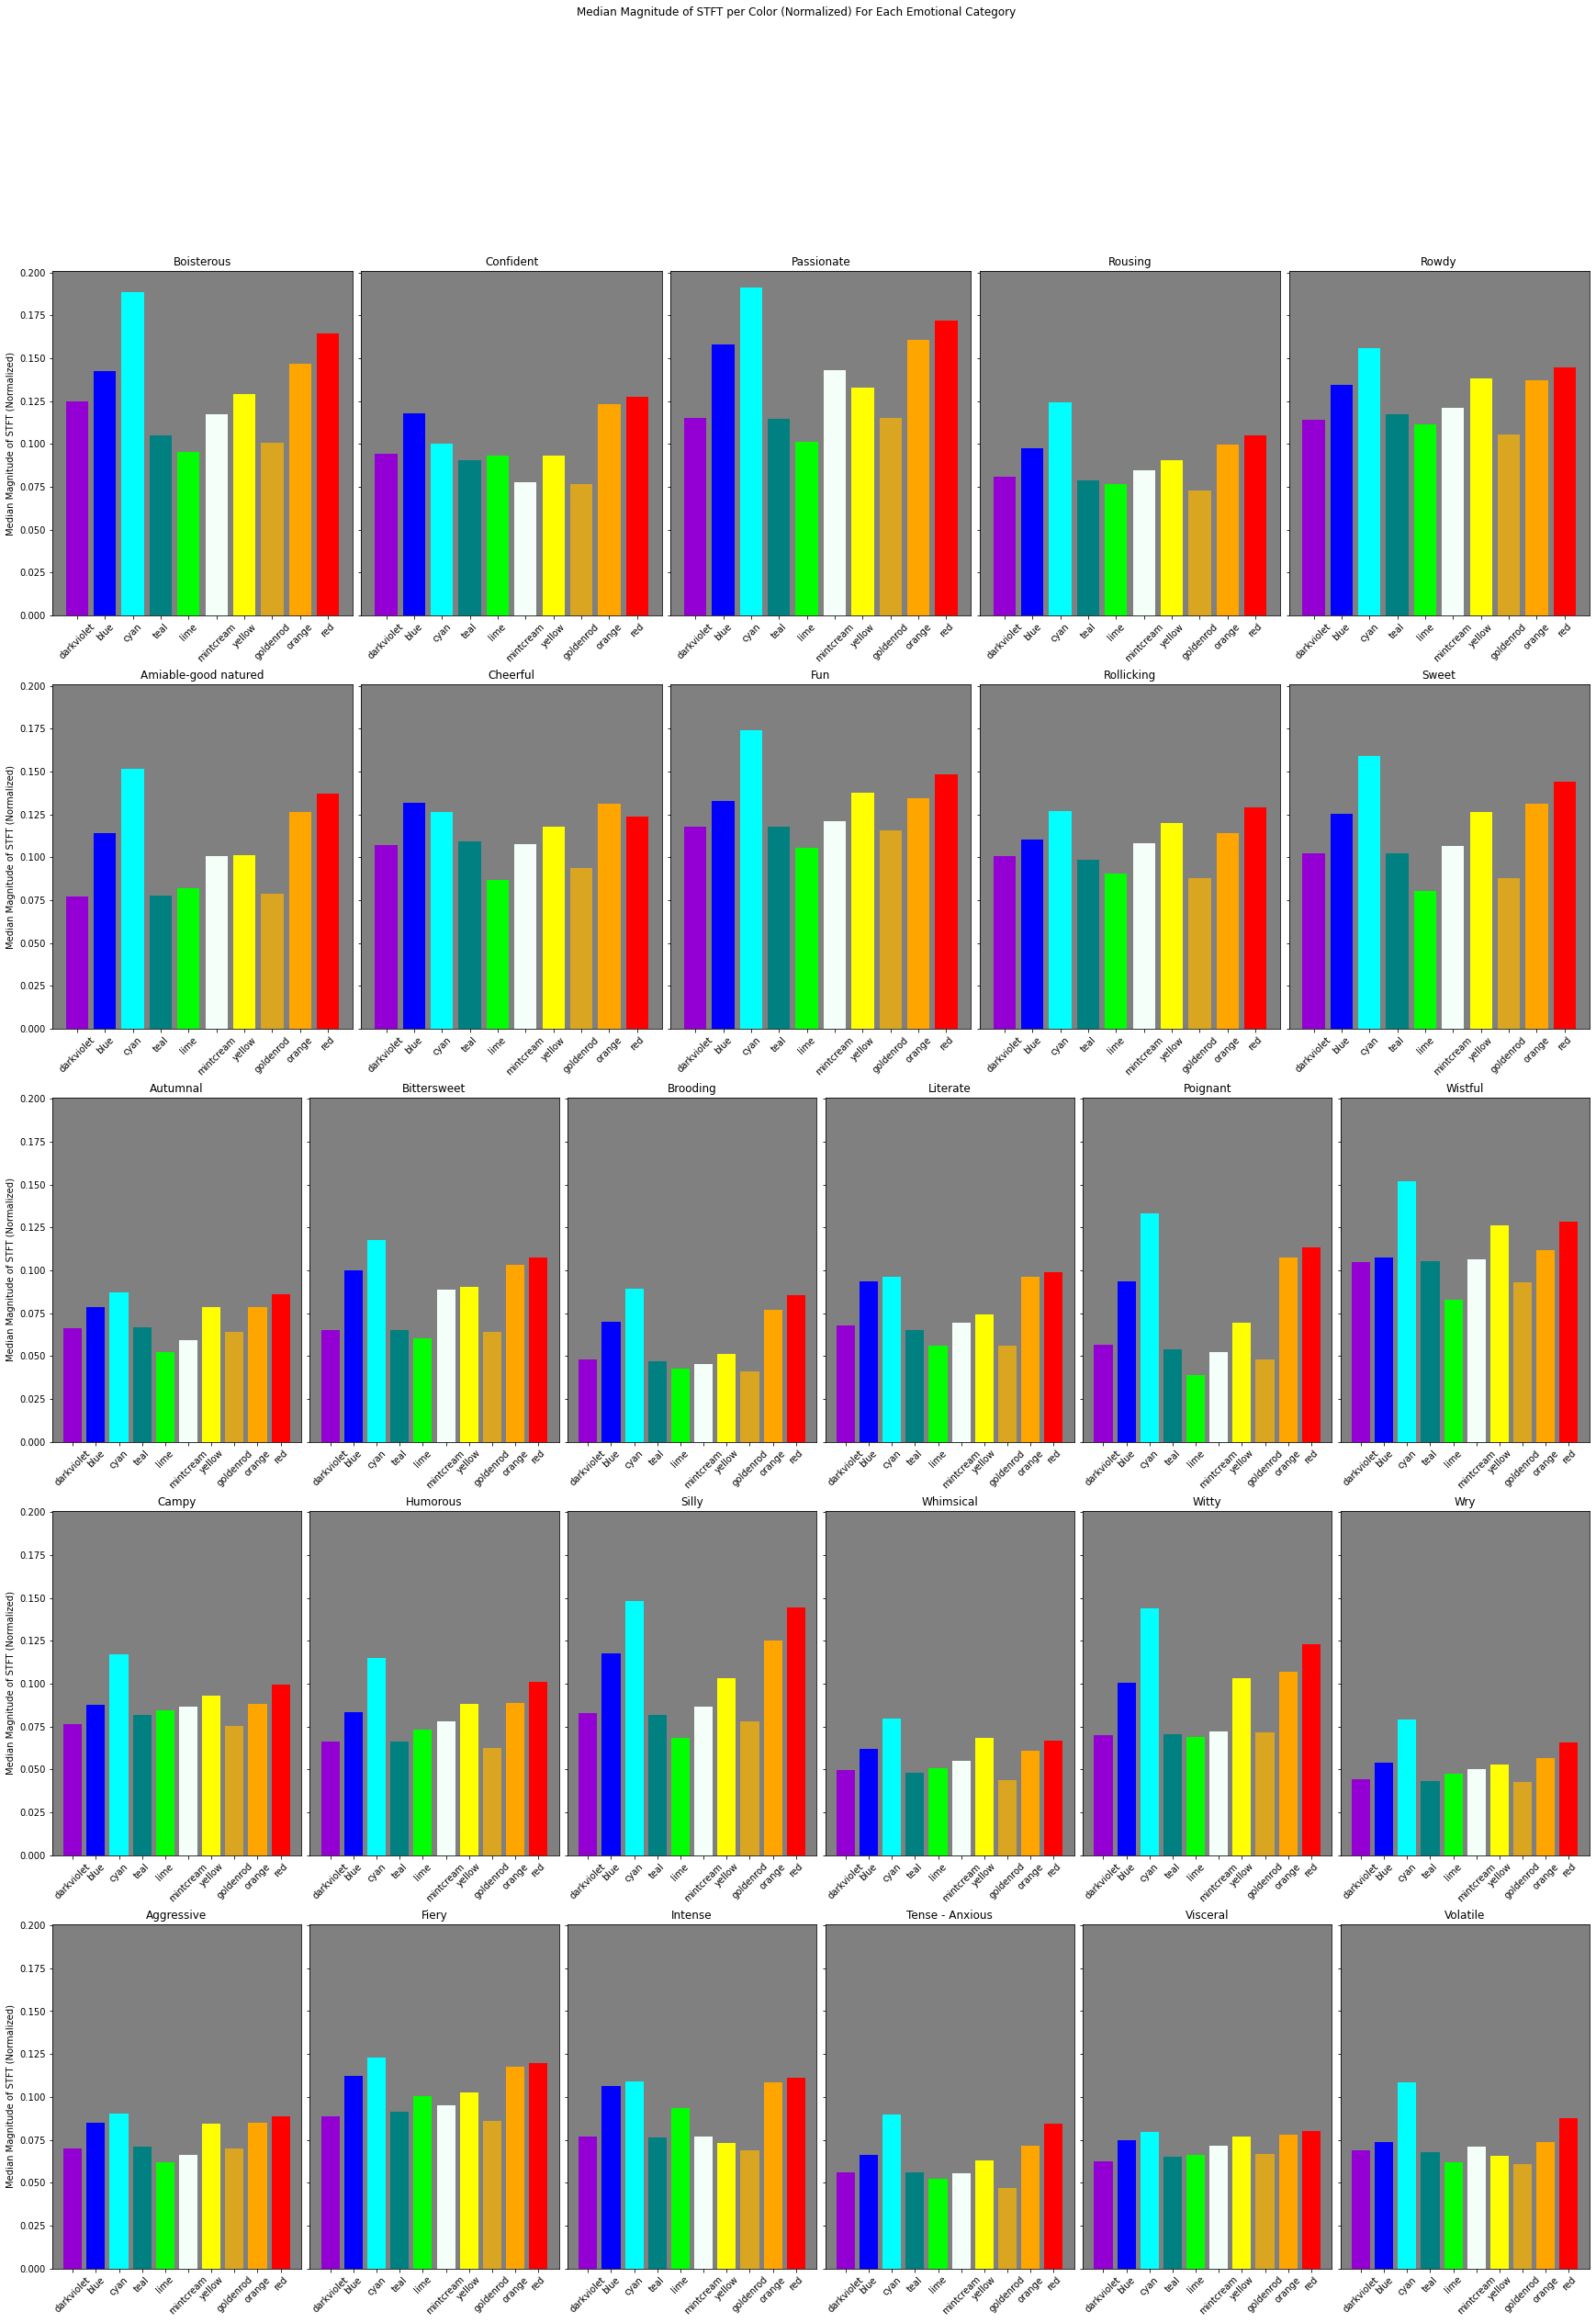

In [13]:
fig = plt.figure(figsize=(30, 40))
gs = GridSpec(5, 30, figure=fig)

ax1_1 = fig.add_subplot(gs[0, 0:6])
ax1_2 = fig.add_subplot(gs[0, 6:12], sharey=ax1_1)
ax1_3 = fig.add_subplot(gs[0, 12:18], sharey=ax1_2)
ax1_4 = fig.add_subplot(gs[0, 18:24], sharey=ax1_3)
ax1_5 = fig.add_subplot(gs[0, 24:], sharey=ax1_4)
plt.setp(ax1_2.get_yticklabels(), visible=False)
plt.setp(ax1_3.get_yticklabels(), visible=False)
plt.setp(ax1_4.get_yticklabels(), visible=False)
plt.setp(ax1_5.get_yticklabels(), visible=False)

ax2_1 = fig.add_subplot(gs[1, 0:6], sharex=ax1_1, sharey=ax1_1)
ax2_2 = fig.add_subplot(gs[1, 6:12], sharex=ax1_2, sharey=ax2_1)
ax2_3 = fig.add_subplot(gs[1, 12:18], sharex=ax1_3, sharey=ax2_2)
ax2_4 = fig.add_subplot(gs[1, 18:24], sharex=ax1_4, sharey=ax2_3)
ax2_5 = fig.add_subplot(gs[1, 24:], sharex=ax1_5, sharey=ax2_4)
plt.setp(ax2_2.get_yticklabels(), visible=False)
plt.setp(ax2_3.get_yticklabels(), visible=False)
plt.setp(ax2_4.get_yticklabels(), visible=False)
plt.setp(ax2_5.get_yticklabels(), visible=False)

ax3_1 = fig.add_subplot(gs[2, 0:5], sharey=ax1_1)
ax3_2 = fig.add_subplot(gs[2, 5:10], sharey=ax3_1)
ax3_3 = fig.add_subplot(gs[2, 10:15], sharey=ax3_2)
ax3_4 = fig.add_subplot(gs[2, 15:20], sharey=ax3_3)
ax3_5 = fig.add_subplot(gs[2, 20:25], sharey=ax3_4)
ax3_6 = fig.add_subplot(gs[2, 25:], sharey=ax3_5)
plt.setp(ax3_2.get_yticklabels(), visible=False)
plt.setp(ax3_3.get_yticklabels(), visible=False)
plt.setp(ax3_4.get_yticklabels(), visible=False)
plt.setp(ax3_5.get_yticklabels(), visible=False)
plt.setp(ax3_6.get_yticklabels(), visible=False)

ax4_1 = fig.add_subplot(gs[3, 0:5], sharex=ax3_1, sharey=ax1_1)
ax4_2 = fig.add_subplot(gs[3, 5:10], sharex=ax3_2, sharey=ax4_1)
ax4_3 = fig.add_subplot(gs[3, 10:15], sharex=ax3_3, sharey=ax4_2)
ax4_4 = fig.add_subplot(gs[3, 15:20], sharex=ax3_4, sharey=ax4_3)
ax4_5 = fig.add_subplot(gs[3, 20:25], sharex=ax3_5, sharey=ax4_4)
ax4_6 = fig.add_subplot(gs[3, 25:], sharex=ax3_6, sharey=ax4_5)
plt.setp(ax4_2.get_yticklabels(), visible=False)
plt.setp(ax4_3.get_yticklabels(), visible=False)
plt.setp(ax4_4.get_yticklabels(), visible=False)
plt.setp(ax4_5.get_yticklabels(), visible=False)
plt.setp(ax4_6.get_yticklabels(), visible=False)

ax5_1 = fig.add_subplot(gs[4, 0:5], sharex=ax4_1, sharey=ax1_1)
ax5_2 = fig.add_subplot(gs[4, 5:10], sharex=ax4_2, sharey=ax5_1)
ax5_3 = fig.add_subplot(gs[4, 10:15], sharex=ax4_3, sharey=ax5_2)
ax5_4 = fig.add_subplot(gs[4, 15:20], sharex=ax4_4, sharey=ax5_3)
ax5_5 = fig.add_subplot(gs[4, 20:25], sharex=ax4_5, sharey=ax5_4)
ax5_6 = fig.add_subplot(gs[4, 25:], sharex=ax4_6, sharey=ax5_5)
plt.setp(ax5_2.get_yticklabels(), visible=False)
plt.setp(ax5_3.get_yticklabels(), visible=False)
plt.setp(ax5_4.get_yticklabels(), visible=False)
plt.setp(ax5_5.get_yticklabels(), visible=False)
plt.setp(ax5_6.get_yticklabels(), visible=False)

fig.patch.set_facecolor('white')
fig.suptitle('Median Magnitude of STFT per Color (Normalized) For Each Emotional Category')

def get_magnitude_per_color(cluster, category):
    results = analyze_category_median_magnitude_for_each_color('archive/dataset/Audio/Cluster {}/{}'.format(cluster, category))
    medians = {color: np.median(results[color]) for color in results}    
    return medians

def plot_medians(medians, category, ax, ylabel=False):
    ax.bar(np.arange(len(colors)), [medians[color] for color in colors] , color=colors)
    ax.set_title(category)
    if ylabel:
        ax.set_ylabel('Median Magnitude of STFT (Normalized)')
    ax.set_xticks(np.arange(len(colors)))
    ax.set_xticklabels(colors, rotation=45)
    ax.set_facecolor('gray')

# boisterous = get_magnitude_per_color(1, 'Boisterous')
# confident = get_magnitude_per_color(1, 'Confident')
# passionate = get_magnitude_per_color(1, 'Passionate')
# rousing = get_magnitude_per_color(1, 'Rousing')
# rowdy = get_magnitude_per_color(1, 'Rowdy')

# amiable_good_natured = get_magnitude_per_color(2, 'Amiable-good natured')
# cheerful = get_magnitude_per_color(2, 'Cheerful')
# fun = get_magnitude_per_color(2, 'Fun')
# rollicking = get_magnitude_per_color(2, 'Rollicking')
# sweet = get_magnitude_per_color(2, 'Sweet')

# autumnal = get_magnitude_per_color(3, 'Autumnal')
# bittersweet = get_magnitude_per_color(3, 'Bittersweet')
# brooding = get_magnitude_per_color(3, 'Brooding')
# literate = get_magnitude_per_color(3, 'Literate')
# poignant = get_magnitude_per_color(3, 'Poignant')
# wistful = get_magnitude_per_color(3, 'Wistful')

# campy = get_magnitude_per_color(4, 'Campy')
# humorous = get_magnitude_per_color(4, 'Humorous')
# silly = get_magnitude_per_color(4, 'Silly')
# whimsical = get_magnitude_per_color(4, 'Whimsical')
# witty = get_magnitude_per_color(4, 'Witty')
# wry = get_magnitude_per_color(4, 'Wry')

# aggressive = get_magnitude_per_color(5, 'Aggressive')
# fiery = get_magnitude_per_color(5, 'Fiery')
# intense = get_magnitude_per_color(5, 'Intense')
# tense_anxious = get_magnitude_per_color(5, 'Tense - Anxious')
# visceral = get_magnitude_per_color(5, 'Visceral')
# volatile = get_magnitude_per_color(5, 'Volatile')

plot_medians(boisterous, 'Boisterous', ax1_1, ylabel=True)
plot_medians(confident, 'Confident', ax1_2)
plot_medians(passionate, 'Passionate', ax1_3)
plot_medians(rousing, 'Rousing', ax1_4)
plot_medians(rowdy, 'Rowdy', ax1_5)

plot_medians(amiable_good_natured, 'Amiable-good natured', ax2_1, ylabel=True)
plot_medians(cheerful, 'Cheerful', ax2_2)
plot_medians(fun, 'Fun', ax2_3)
plot_medians(rollicking, 'Rollicking', ax2_4)
plot_medians(sweet, 'Sweet', ax2_5)

plot_medians(autumnal, 'Autumnal', ax3_1, ylabel=True)
plot_medians(bittersweet, 'Bittersweet', ax3_2)
plot_medians(brooding, 'Brooding', ax3_3)
plot_medians(literate, 'Literate', ax3_4)
plot_medians(poignant, 'Poignant', ax3_5)
plot_medians(wistful, 'Wistful', ax3_6)

plot_medians(campy, 'Campy', ax4_1, ylabel=True)
plot_medians(humorous, 'Humorous', ax4_2)
plot_medians(silly, 'Silly', ax4_3)
plot_medians(whimsical, 'Whimsical', ax4_4)
plot_medians(witty, 'Witty', ax4_5)
plot_medians(wry, 'Wry', ax4_6)

plot_medians(aggressive, 'Aggressive', ax5_1, ylabel=True)
plot_medians(fiery, 'Fiery', ax5_2)
plot_medians(intense, 'Intense', ax5_3)
plot_medians(tense_anxious, 'Tense - Anxious', ax5_4)
plot_medians(visceral, 'Visceral', ax5_5)
plot_medians(volatile, 'Volatile', ax5_6)

fig.savefig('Categories.png', facecolor=fig.get_facecolor())